## Cab Driver Agent
---


In [1]:
%config IPCompleter.greedy = True

In [2]:
import collections
import numpy as np
import random
import pickle
import time
import os

from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from matplotlib import pyplot as plt
from itertools import product
from collections import defaultdict, deque
from datetime import datetime

from cab_environment import CabDriverEnvironment

%matplotlib inline

Using TensorFlow backend.


### State Tracking
---

#### tracking states initialization

In [3]:
def initialize_tracking_states():
    state_action_pair = [((1, 0, 0), (1, 2)),
                         ((1, 1, 1), (4, 5)),
                         ((2, 2, 2), (1, 3)),
                         ((2, 2, 2), (3, 4)),
                         ((3, 3, 3), (3, 2)),
                         ((3, 3, 3), (4, 5)),
                         ((4, 4, 4), (4, 1)), 
                         ((4, 4, 4), (2, 1)),
                         ((5, 5, 5), (1, 2)),
                         ((5, 5, 5), (2, 3))]

    for st, ac in state_action_pair:
        if st not in tracked_states:
            tracked_states[st] = defaultdict()
        tracked_states[st][ac] = list()

#### persist q-values corresponding to tracked states

In [4]:
def update_tracking_states(driver):
    for state in tracked_states.keys():
        encoded_state = driver.cab_environment.state_encod_arch1(state)
        q_predict = driver.model.predict(encoded_state)

        for action in tracked_states[state].keys():
            action_index = list(
                filter(
                    lambda x: action == driver.cab_environment.action_space[x],
                    range(0, len(driver.cab_environment.action_space))))[0]
            q_value = q_predict[0][action_index]
            tracked_states[state][action].append(q_value)

#### save model object

In [5]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Epsilon - Greedy Strategy
---

Epsilon greedy policy is a way of selecting random actions with uniform distribution from a set of available actions. Using this policy either we can select random action with epsilon probability and we can select an action with 1-epsilon probability that gives maximum reward in given state

#### check epsilon decay over episodes

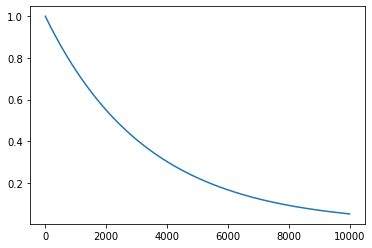

In [6]:
epsilon = []
max_epsilon = 1.0
min_epsilon = 0.001

# number of episodes for training : 10,000
episodes = np.arange(0, 10000)

for i in episodes:
    epsilon.append(min_epsilon +
                   (max_epsilon - min_epsilon) * np.exp(-0.0004 * i))

plt.plot(episodes, epsilon)
plt.show()

>  formula to calculate epsilon : **(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.0003 * i))**
-  minimum epsilon : 0.001
-  maximum epsilon : 1.0

### DQN Agent Class
---

#### Q-Network Architecture
---

- input : encoded state i.e. each vector is a combination of locations + hours in a day + days in a week
- output : q-values for all actions including (0, 0)

#### Hyper parameters
---

- state_size : vector length of encoded states (number of neurons in input layer) : (36 -> 5 cities + 24 hours + 7 days)
- action_size : vector length of predicted q_values for all actions : (21 -> (4*5) + 1  -> (m-1 * m) + 1) )
- learning_rate
- discount_factor
- batch_size : batch size used in neural network for training
- memory_length : replay memory buffer size
- nn_epochs : number of epochs for neural network

In [7]:
class DQNAgent:
    def __init__(self,
                 state_size,
                 action_size,
                 learning_rate=0.09,
                 gamma=0.95,
                 batch_size=32,
                 memory_length=2000,
                 nn_epochs=1):

        self.set_hyperparameters(state_size, action_size, learning_rate, gamma,
                                 batch_size, memory_length, nn_epochs)

        # environment object
        self.cab_environment = CabDriverEnvironment()

        # create main and target model
        self.model = self.build_model()

        # create a model directory
        self.create_model_dir()

    def set_hyperparameters(self, state_size, action_size, learning_rate,
                            gamma, batch_size, memory_length, nn_epochs):
        # initialize state-size and action-size which is define the input and output neurons
        # of the neural network.
        #
        # state_size = number of locations(5) + hours in a day (24) + days in a week (7)
        # action_size = total number of possible actions from a given state i.e. ((m-1) * m) + 1
        #
        # number of neurons in the input layer : state_size
        # number of neurons in the output layer : action_size
        self.state_size = state_size
        self.action_size = action_size

        # define hyperparameters to be used for training the model
        self.hyperparameters = {
            'learning_rate': learning_rate,
            'gamma': gamma,
            'batch_size': batch_size,
            'memory_length': memory_length,
            'nn_epochs': nn_epochs
        }

        # replay memory for DQN
        self.replay_memory = collections.deque(
            maxlen=self.hyperparameters['memory_length'])

    def create_model_dir(self):
        lrate = self.hyperparameters['learning_rate']
        gamma = self.hyperparameters['gamma']
        bsize = self.hyperparameters['batch_size']
        
        self.model_dir = 'rl_cab_model_arch1_lrate_{0}_gamma_{1}_batch_size_{2}'.format(lrate, gamma, bsize)

        if not os.path.exists(self.model_dir):
            os.mkdir(self.model_dir)

    def build_model(self):
        """ Build neural network model
        """
        model = Sequential()

        # Input layer : 'state_size'
        model.add(
            Dense(32,
                  input_dim=self.state_size,
                  activation='relu',
                  kernel_initializer='he_uniform'))

        # Hidden Layers
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))

        # Output Layer : 'action_size'
        model.add(
            Dense(self.action_size,
                  activation='relu',
                  kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(lr=self.hyperparameters['learning_rate']))

        model.summary()

        return model

    def get_action(self, state, episode):
        """ Choose an action for a given state and episode based on
            Epsilon-Greedy strategy
        """
        epsilon_min = 0.0009
        epsilon_max = 1.0
        
        # calculate decay factor for a given episode
        epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(-0.0003 * episode)

        random_value = np.random.random()
        
        # fetch possible requests and their index for a given location
        # number of requests per location are calculated based on a poisson distribution
        possible_requests_index, possible_requests = self.cab_environment.get_requests_per_location(state)
        
        if random_value > epsilon:
            # exploitation
            
            # predict q-values of all possible actions for a given state
            encoded_state = self.cab_environment.state_encod_arch1(state)
            predicted_q_values = self.model.predict(encoded_state)
            
            # filter q-values corresponding to selected requests for a given location
            filter_q_values = [predicted_q_values[0][i] for i in possible_requests_index]
            
            # select index of an action corresponding to max Q-value
            index_max_q_value = np.argmax(np.array(filter_q_values))

            # select request with maximum q-value
            selected_action = possible_requests[index_max_q_value]

        else:
            # exploration

            # select a random request from possible request space
            selected_action = random.choice(possible_requests)
            
        return selected_action

    def append_sample(self, state, action, reward, next_state):
        self.replay_memory.append((state, action, reward, next_state))

    def train_model(self):
        """ Pick samples randomly from replay memory (with batch_size) and train the network
        """
        # start training only when the number of samples in memory > batch size
        if len(self.replay_memory) > self.hyperparameters['batch_size']:
            
            batch_size = self.hyperparameters['batch_size']

            # Sample batch from the memory
            mini_batch = random.sample(self.replay_memory, batch_size)

            # initialize input state vector S
            encoded_state_input = np.zeros((batch_size, self.state_size))

            # initialize input state vector S'
            encoded_next_state_input = np.zeros((batch_size, self.state_size))

            action_list, reward_list = [], []

            # for each element in the mini-batch, update input vectors
            # with encoded state values
            for i in range(batch_size):
                state, action, reward, next_state = mini_batch[i]

                encoded_state = self.cab_environment.state_encod_arch1(state)
                encoded_state_input[i] = encoded_state

                encoded_next_state = self.cab_environment.state_encod_arch1(
                    next_state)
                encoded_next_state_input[i] = encoded_next_state

                action_list.append(action)
                reward_list.append(reward)

            # once the input matrices S and S' have been created, perform a feed-forward.
            # this will generate q-values for all possible actions of a batch input
            
            # generate Q(s, a)
            current_state_q_values = self.model.predict(encoded_state_input)
            
            # generate Q(s', a)
            next_state_q_values = self.model.predict(encoded_next_state_input)
            
            # for each element in the batch, update respective q-values using the
            # predicted and target q-values
            for i in range(batch_size):
                # each memory element is of form (s, a, s', r)
                # output of NN for a given state generates q-values for all possible actions
                # hence q-value update must be made to only that action 'a' 
                # out of all possible actions in the output

                # given an action 'a', find the corresponding action index
                performed_action = list(
                    filter(
                        lambda x: self.cab_environment.action_space[x] == action_list[i],
                        range(0, len(self.cab_environment.action_space))))[0]
                
                # update q-value using formula (r + max Q(s',a))
                current_state_q_values[i][performed_action] = reward_list[i] + (
                    self.hyperparameters['gamma'] *
                    np.max(next_state_q_values))
            
            # train the model with update Q-values
            self.model.fit(encoded_state_input,
                           current_state_q_values,
                           batch_size=batch_size,
                           epochs=self.hyperparameters['nn_epochs'],
                           verbose=0)

    def save(self):
        f_name = self.model_dir + "/" + "dqn_model_" + datetime.now().strftime("%Y%m%d_%H%M%S")
        save_obj(self.model, f_name)

### Initialization
---

#### tracking states

In [8]:
tracked_states = defaultdict()
initialize_tracking_states()
tracked_states

defaultdict(None,
            {(1, 0, 0): defaultdict(None, {(1, 2): []}),
             (2, 2, 2): defaultdict(None, {(3, 4): []}),
             (3, 5, 6): defaultdict(None, {(3, 3): []}),
             (5, 0, 0): defaultdict(None, {(2, 3): []}),
             (4, 14, 4): defaultdict(None, {(4, 3): []})})

#### tracking variables

In [9]:
total_episodes = 5000

checkpoint_print_episodes = 100

month_end_cost_time = 30 * 24

training_total_rewards_distribution = []
training_total_ride_time_distribution = []
training_total_time_step_distribution = []

#### agent class

In [10]:
driver_A = DQNAgent(state_size=36,
                    action_size=21,
                    learning_rate=0.01,
                    gamma=0.85,
                    batch_size=32,
                    memory_length=2000,
                    nn_epochs=3)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


### Q - Learning
---

In [11]:
def train_agent(driver):
    start_time = time.time()

    for episode in range(total_episodes):

        # reset driver state at the beginning of each episode
        current_state = driver.cab_environment.set_init_state()

        # reset temporary tracking variables
        has_reached_terminal_state = False
        total_ride_time_per_episode = 0
        total_rewards_per_episode = 0
        time_step_per_episode = 0

        while not has_reached_terminal_state:

            # get the current action based on epsilon-greedy strategy
            current_action = driver.get_action(current_state, episode)

            # given the current state and action, calculate next state, reward and ride time
            next_state, total_rewards, total_ride_time = driver.cab_environment.get_next_state(
                current_state, current_action)

            total_ride_time_per_episode += total_ride_time
            total_rewards_per_episode += total_rewards

            if total_ride_time_per_episode >= month_end_cost_time:
                has_reached_terminal_state = True

            # append current experience to replay buffer
            driver.append_sample(current_state, current_action, total_rewards, next_state)

            # train the model
            driver.train_model()

            current_state = next_state
            time_step_per_episode += 1

        training_total_rewards_distribution.append(total_rewards_per_episode)
        training_total_ride_time_distribution.append(total_ride_time_per_episode)
        training_total_time_step_distribution.append(time_step_per_episode)
        update_tracking_states(driver)
        
        if (episode + 1) % checkpoint_print_episodes == 0:
            print(
                "Episode : %d, Avg Monthly Reward : %f, Avg Ride Time : %f, Avg Per Episode Time Step : %f"
                % (episode + 1,
                   np.mean(training_total_rewards_distribution),
                   np.mean(training_total_ride_time_distribution),
                   np.mean(training_total_time_step_distribution)))

    elapsed_time = time.time() - start_time
    print("Elapsed time :", elapsed_time)

In [11]:
# running for 5000 episodes with a decay of 0.0009
train_agent(driver_A)

Instructions for updating:
Use tf.cast instead.
Episode : 200, Last Episode Reward = -152.000000, Avg Monthly Reward : -156.995000, Avg Ride Time : 723.580000, Avg Per Episode Time Step : 140.650000
Episode : 400, Last Episode Reward = -113.000000, Avg Monthly Reward : -128.517500, Avg Ride Time : 723.685000, Avg Per Episode Time Step : 140.870000
Episode : 600, Last Episode Reward = 145.000000, Avg Monthly Reward : -105.028333, Avg Ride Time : 723.716667, Avg Per Episode Time Step : 142.116667
Episode : 800, Last Episode Reward = -173.000000, Avg Monthly Reward : -89.033750, Avg Ride Time : 723.760000, Avg Per Episode Time Step : 142.342500
Episode : 1000, Last Episode Reward = -234.000000, Avg Monthly Reward : -66.352000, Avg Ride Time : 723.689000, Avg Per Episode Time Step : 143.029000
Episode : 1200, Last Episode Reward = 16.000000, Avg Monthly Reward : -51.387500, Avg Ride Time : 723.670000, Avg Per Episode Time Step : 143.757500
Episode : 1400, Last Episode Reward = -209.000000,

#### save model object
---

In [25]:
driver_A.save()

### Tracking Convergence
---

In [38]:
 for st in tracked_states.keys():
        for ac in tracked_states[st].keys():
            number_of_tracked_q_values = len(list(filter(lambda x: x!= 0, tracked_states[st][ac])))
            print('state - {0} - action - {1} - {2}'.format(st, ac, number_of_tracked_q_values))

state - (1, 0, 0) - action - (1, 2) - 500
state - (1, 0, 0) - action - (0, 0) - 0
state - (2, 2, 2) - action - (2, 3) - 0
state - (2, 2, 2) - action - (3, 4) - 500
state - (3, 3, 3) - action - (0, 0) - 0
state - (3, 3, 3) - action - (4, 5) - 500
state - (4, 4, 4) - action - (0, 0) - 0
state - (4, 4, 4) - action - (2, 1) - 0
state - (5, 5, 5) - action - (1, 2) - 500
state - (5, 5, 5) - action - (0, 0) - 0


#### selecting only the states with non-zero values

In [70]:
tracked_states_plotting = [((1, 0, 0), (1, 2)), 
                           ((2, 2, 2), (3, 4)),
                           ((3, 3, 3), (4, 5)), 
                           ((5, 5, 5), (1, 2))]

#### draw convergence plot for a state - action pair
---

In [46]:
def plot_q_val_convergence(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.plot(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - Action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

In [67]:
def plot_q_val_log_convergence(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.semilogy(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - Action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

#### display convergence of tracked states
---

<Figure size 1440x1080 with 0 Axes>

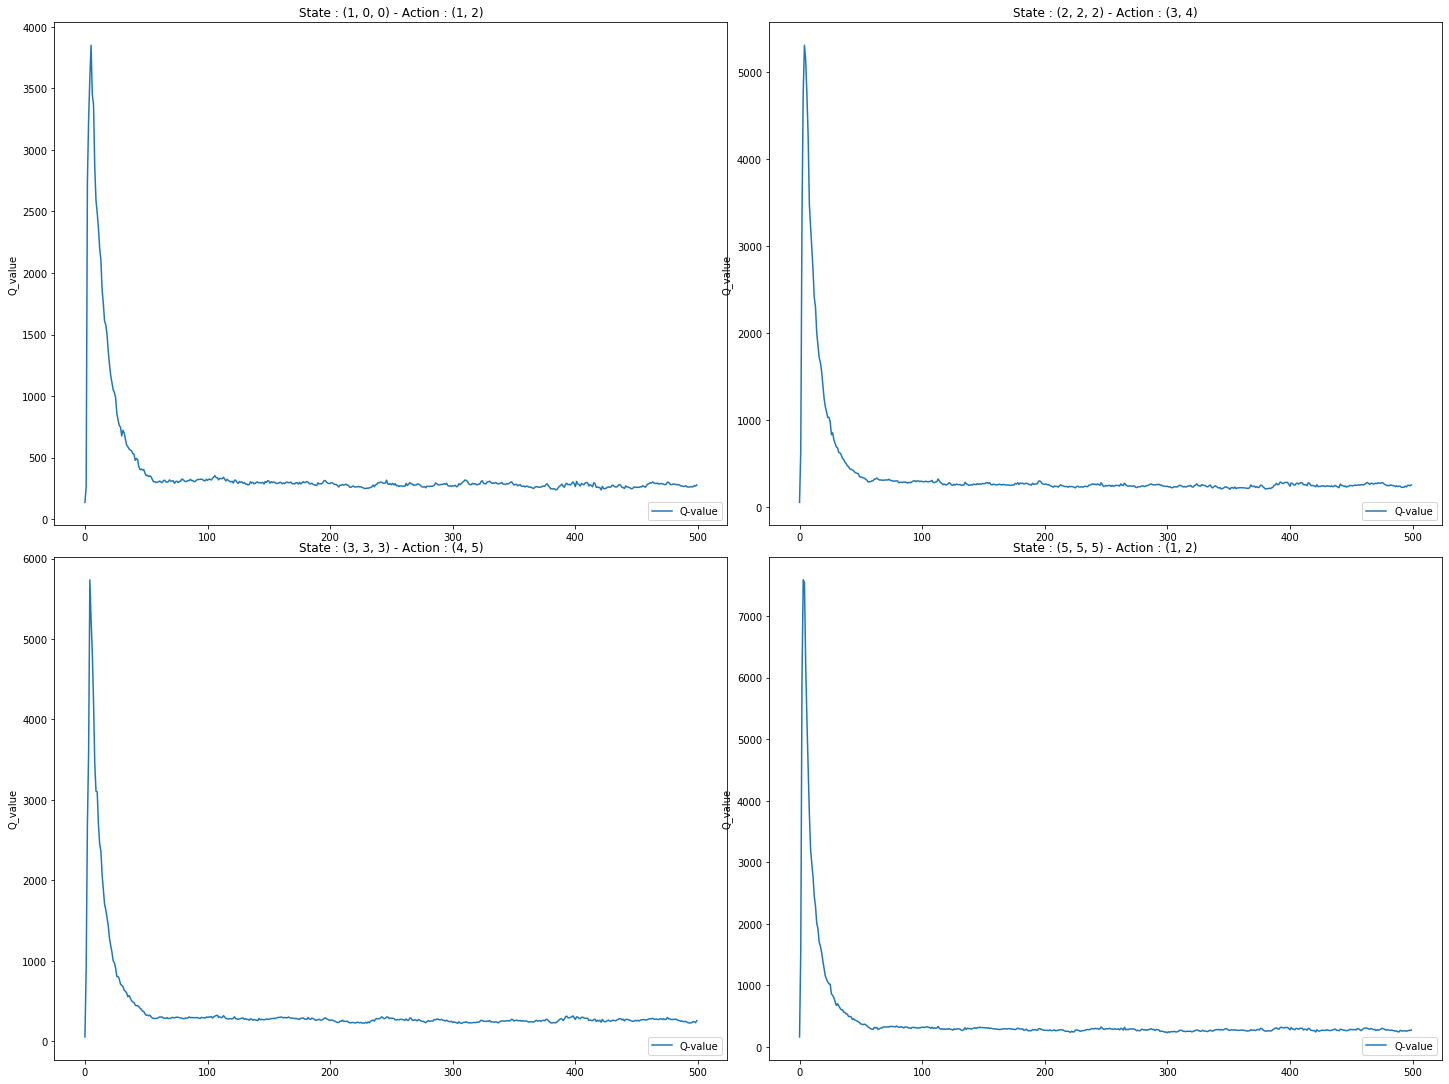

In [75]:
plt.figure(0, figsize=(20, 15))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
fig.tight_layout()

subplots = [i for i in range(221, 225)]

i = 0

for state, action in tracked_states_plotting:
    if i < 4:
        plt.subplot(subplots[i])
        plot_q_val_convergence(state, action)
        i +=1

plt.show()

<Figure size 1440x1080 with 0 Axes>

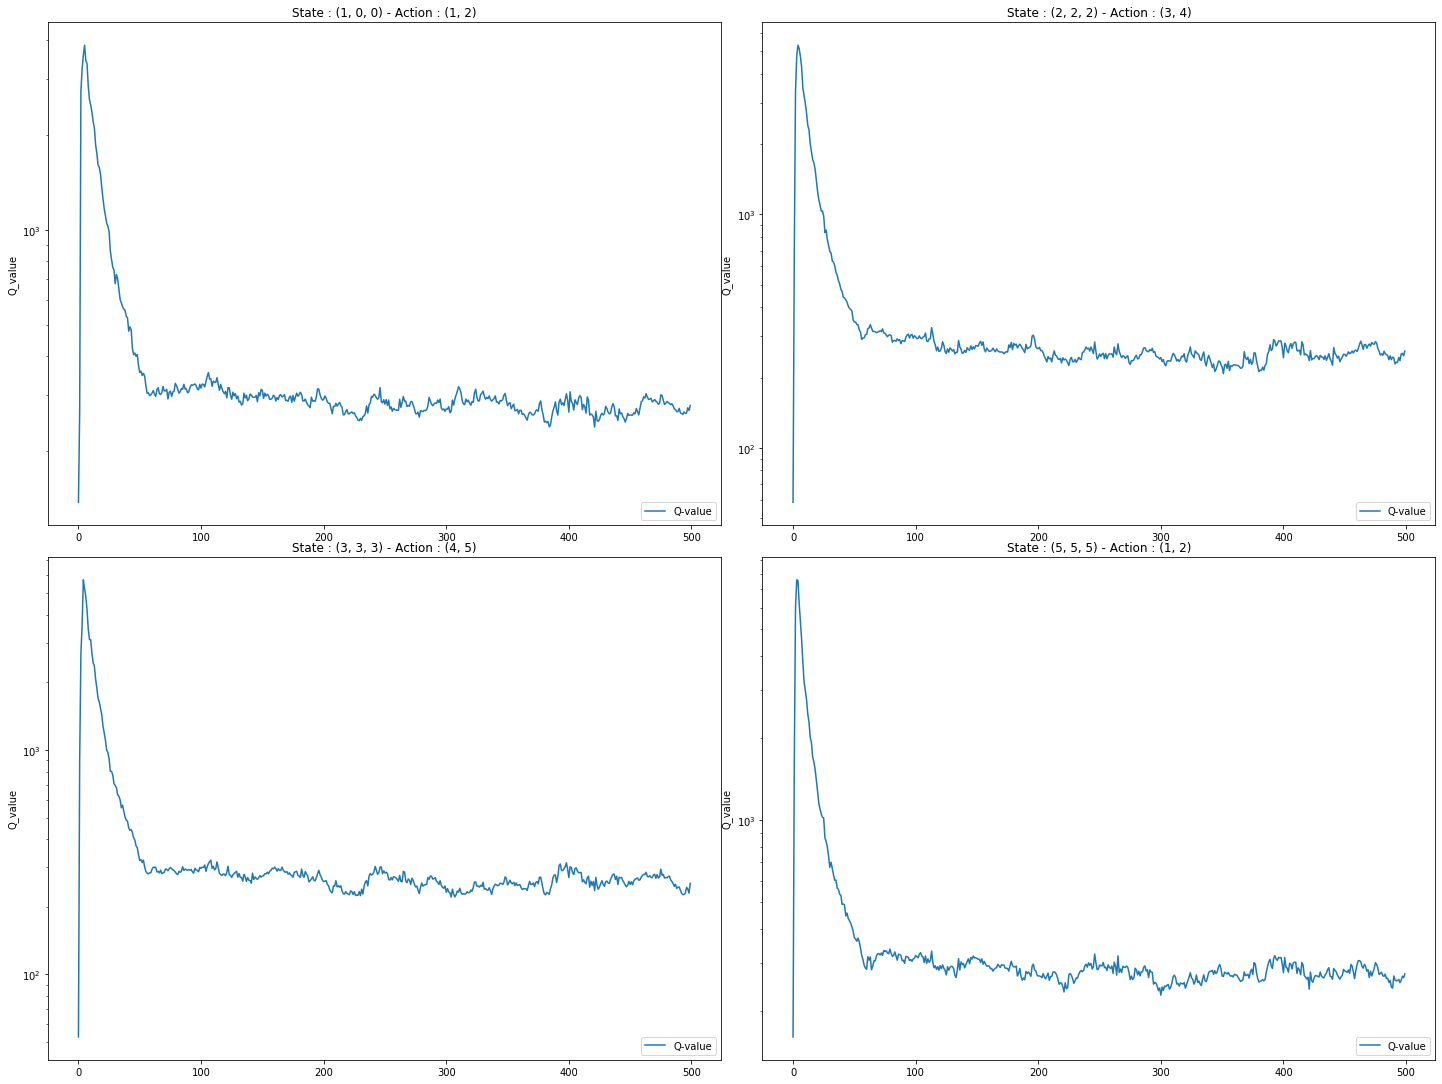

In [76]:
plt.figure(0, figsize=(20, 15))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
fig.tight_layout()

subplots = [i for i in range(221, 225)]

i = 0

for state, action in tracked_states_plotting:
    if i < 4:
        plt.subplot(subplots[i])
        plot_q_val_log_convergence(state, action)
        i +=1

plt.show()

### Plotting Average Monthly Rewards
---

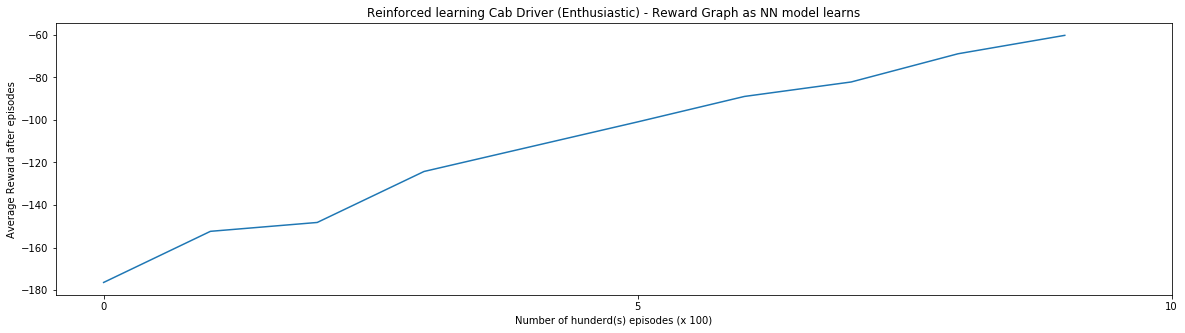

In [27]:
avg_as_model_learnt = [
    np.mean(training_total_rewards_distribution[0:x + 99])
    for x in range(0, 10000, 100)
]

plt.figure(figsize=(20, 5))

plt.plot(range(0, len(avg_as_model_learnt)), avg_as_model_learnt)

plt.xlabel("Number of hunderd(s) episodes (x 100)")
plt.ylabel("Average Reward after episodes")
plt.title("Reward Graph")
plt.xticks(range(0, 15, 5))

plt.show()